In [12]:
import numpy as np
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from helpers import load_dataset_path, load_image, resize_image
from pathlib import Path
import config
from callbacks import plot_predictions
from helpers import print_array_properties


In [13]:
model = load_model(config.model.full_path)

images = load_dataset_path(Path('images/training/test/0'), limit=2)

arr = [resize_image(load_image(image), 512, 512) for image in images]

print(arr[0].shape)
print(len(arr))


(512, 512, 3)
2


In [14]:
x_test = (np.stack(arr) / 255).astype(np.float32)

print_array_properties('x_test', x_test)


X_TEST
Length: 2
Shape: (2, 512, 512, 3)
Size: 0.006 GB



1/1 [==============================] - 0s 303ms/step
Y_PRED
Length: 2
Shape: (2, 512, 512, 1)
Size: 0.002 GB



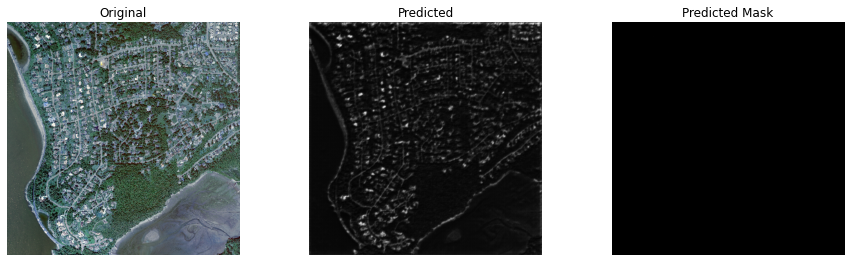

In [16]:
y_pred = model.predict(x_test, verbose=1)

print_array_properties('y_pred', y_pred)

y_pred_mask = (y_pred > 0.5).astype(np.uint8)

plot_predictions(original=x_test, predicted=y_pred, predicted_mask=y_pred_mask)


In [ ]:


# https://www.jeremyjordan.me/evaluating-image-segmentation-models/

# result = cv2.bitwise_and(test_split[0], test_split[0], mask=prediction[0])

# result

# https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2

# https://www.jeremyjordan.me/evaluating-image-segmentation-models/


In [19]:
# IoU - Intersection over Union

intersection = np.logical_and(x_test, y_pred)
union = np.logical_or(x_test, y_pred)
iou_score = np.sum(intersection) / np.sum(union)
iou_score

0.9991308848063151

In [24]:
from keras import backend as K

def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

In [26]:
iou_coef(x_test, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=0.099831>

In [27]:
def dice_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(y_true * y_pred, axis=[1,2,3])
  union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
  dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
  return dice

In [28]:
dice_coef(x_test, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=0.18141851>

In [ ]:
# ========================== VALIDATION ========================== #
print()
print('----- FINAL VALIDATION -----')

model = load_model(config.model.full_path)
x_val_pred = model.predict(x_val, verbose=1, batch_size=config.model_params.batch_size)
model.evaluate(x=x_val, y=y_val, batch_size=config.model_params.batch_size)
# simple threshold to change to 1/0, mask
x_val_pred_mask = (x_val_pred > 0.5).astype(np.uint8)

plot_predictions(
    original=x_val, predicted=x_val_pred, predicted_mask=x_val_pred_mask, ground_truth=y_val
)